In [1]:
from imutils import paths
import argparse
import time
import sys
import cv2
import os
import imagehash
from PIL import Image

## Version 1

In [ ]:
def dhash(image, hashSize=8):
    # resize the input image, adding a single column (width) so we
    # can compute the horizontal gradient
    resized = cv2.resize(image, (hashSize + 1, hashSize))
    
    print(resized.shape)
    # compute the (relative) horizontal gradient between adjacent
    # column pixels
    diff = resized[:, 1:] > resized[:, :-1]
    
    print(diff)
    print(diff.shape)
    # convert the difference image to a hash
    print(diff.flatten())
    return [int(n) for n in str(sum([2 ** i if v else 0 for (i, v) in enumerate(diff.flatten())]))]

In [ ]:
print("[INFO] computing hashes for haystack...")
haystackPaths = list(paths.list_images("haystack"))
needlePaths = list(paths.list_images("needles"))

In [ ]:
test_path = haystackPaths[0]
image = cv2.imread(test_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)

test_hash = dhash(image)
# print(len(test_hash))
print(test_hash)
# imageHash = dhash(image)

In [ ]:
BASE_PATHS = set([p.split(os.path.sep)[-2] for p in needlePaths])
haystack = {}

In [ ]:
from tqdm import tqdm

start = time.time()
# loop over the haystack paths
for p in tqdm(haystackPaths):
    # load the image from disk
    image = cv2.imread(p)

    # if the image is None then we could not load it from disk (so
    # skip it)
    if image is None:
        continue

    # convert the image to grayscale and compute the hash
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imageHash = dhash(image)

    # update the haystack dictionary
    haystack[p] = imageHash

In [ ]:
haystack

In [ ]:
print("[INFO] processed {} images in {:.2f} seconds".format(
    len(haystack), time.time() - start))
print("[INFO] computing hashes for needles...")

In [ ]:
needleStack = {}

In [ ]:
from tqdm import tqdm

for p in tqdm(needlePaths):
    # load the image from disk
    image = cv2.imread(p)

    # if the image is None then we could not load it from disk (so
    # skip it)
    if image is None:
        continue

    # convert the image to grayscale and compute the hash
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imageHash = dhash(image)

    # grab all image paths that match the hash
    needleStack[p] = imageHash

In [ ]:
needleStack

## Version 2

In [ ]:
from scipy.spatial.distance import hamming
from PIL import Image

# img1 = needleStack["needles/defense/paris_defense_000526.jpg"]
# img2 = needleStack["needles/defense/paris_defense_000552.jpg"]


im_1 = cv2.imread("needles/general/paris_general_002654.jpg")
im_2 = cv2.imread("needles/eiffel/paris_eiffel_000284.jpg")

# print(hamming(img1, img2))
hash_1 = [i for i in str(imagehash.phash(Image.open("needles/eiffel/paris_eiffel_000285.jpg")))]
hash_2 = [i for i in str(imagehash.phash(Image.open("needles/eiffel/paris_eiffel_000284.jpg")))]
print(hash_1)
print(hash_2)
# matchedPaths = haystack.get(imageHash, [])

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(im_1)

In [ ]:
plt.imshow(im_2)

In [ ]:
hamming_distance(hash_1, hash_2)

In [ ]:
1 - (hamming_distance(hash_1, hash_2) / 64.0)

In [ ]:
 
i1 = Image.open("needles/general/paris_general_002654.jpg")
i2 = Image.open("needles/eiffel/paris_eiffel_000284.jpg")

i1 = i1.resize((250, 250))
i2 = i2.resize((250, 250))
assert i1.mode == i2.mode, "Different kinds of images."
assert i1.size == i2.size, "Different sizes."
 
pairs = zip(i1.getdata(), i2.getdata())
if len(i1.getbands()) == 1:
    # for gray-scale jpegs
    dif = sum(abs(p1-p2) for p1,p2 in pairs)
else:
    dif = sum(abs(c1-c2) for p1,p2 in pairs for c1,c2 in zip(p1,p2))
 
ncomponents = i1.size[0] * i1.size[1] * 3
print("Similarity (percentage):", 100 - (dif / 255.0 * 100) / ncomponents, "%")

In [ ]:
plt.imshow(i2)

In [ ]:
import image_slicer

lis = image_slicer.slice("needles/general/paris_general_002654.jpg", 6)

In [ ]:
lis

In [ ]:
# for i in lis:
#     plt.imshow(i)

from PIL import ImageDraw, ImageFont


for tile in lis:
    overlay = ImageDraw.Draw(tile.image)
    overlay.text((5, 5), str(tile.number), (255, 255, 255),
                 ImageFont.load_default())

result = image_slicer.save_tiles(lis)

In [ ]:
result

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))

for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
fig=plt.figure(figsize=(8, 8))
kk = []
import numpy
for image in result[0:]:
    im = Image.open(image.filename)
    kk.append(im)
    plt.imshow(numpy.asarray(im))

# plt.imshow(kk[-1])
plt.show()

## Version 3

In [ ]:
# 1 - (phash_distance(phash1, phash2) / 64.0)

# imagehash.ph
# print((hash_1 - hash_2) / 64.0)

def hamming_similarity(s1, s2):
    """Return the Hamming distance between equal-length sequences"""
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return 1 - sum(el1 != el2 for el1, el2 in zip(s1, s2))/ len(s1)

In [2]:
def crop(im_name, parts, size):
    im = Image.open(im_name).resize(size).convert('LA')
    imgwidth, imgheight = im.size
    piece_size = int((imgheight * imgwidth // parts) ** 0.5)
    images = []
    for i in range(imgheight//piece_size + 1):
        for j in range(imgwidth//piece_size):
            box = (j*piece_size, i*piece_size, (j+1)*piece_size, (i+1)*piece_size)
            images.append(im.crop(box))
    return images

In [ ]:
def pHash(image, hash_size=8, highfreq_factor=4):
    """
    file_dir: Directory to the file.
    hash_size: Size of hash.
    returns: Hash of the image.
    """ 
    return imagehash.phash(image, hash_size=hash_size, highfreq_factor=highfreq_factor)

In [61]:
hash_functions = [lambda x: imagehash.phash(x, hash_size=4),
                  lambda x: imagehash.phash(x, hash_size=8),
                  lambda x: imagehash.phash(x, hash_size=16),
                  lambda x: imagehash.dhash(x, hash_size=4),
                  lambda x: imagehash.dhash(x, hash_size=8),
                  lambda x: imagehash.dhash(x, hash_size=16),
                  lambda x: imagehash.whash(x, hash_size=4),
                  lambda x: imagehash.whash(x, hash_size=8),
                  lambda x: imagehash.whash(x, hash_size=16),
                  lambda x: imagehash.average_hash(x, hash_size=4),
                  lambda x: imagehash.average_hash(x, hash_size=8),
                  lambda x: imagehash.average_hash(x, hash_size=16)
                 ]

In [34]:
def get_image_hashes(image_path):
    partitions = crop(image_path, 9, (256,256))
    hashes = {i:[] for i in range(len(hash_functions))}
    for partition in partitions:
        for i in range(len(hash_functions)):
            hashes[i].append(str(hash_functions[i](partition)))
    return {i: min(hashes) for i, hashes in enumerate(hashes.values())}

In [ ]:
def get_image_hashes_2(image_path, hash_size, partitions, size):
    return [str(imagehash.dhash(partition, hash_size=hash_size)) for partition in crop(image_path, partitions, size)]

In [55]:
photo1 = "haystack/paris_louvre_000004.jpg"
# photo2 = "needles/general/paris_general_002655.jpg"
photo2 = "needles/eiffel/paris_eiffel_000285.jpg"

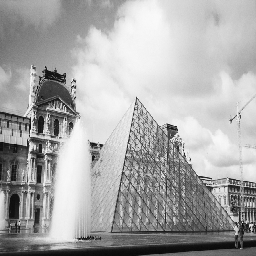

In [60]:
Image.open(photo1).convert('LA').resize((256,256))

In [ ]:
Image.open(photo2).convert('LA')

In [ ]:
import time
start = time.time()
img1 = get_image_hashes(photo1)
time.time() - start

In [ ]:
img2 = get_image_hashes(photo2)

In [ ]:
def calc_similarity(hash1, hash2):
    sum = 0
    for i, j in zip(hash1.values(), hash2.values()):
        a = hamming_similarity(i,j)
        print(i, j)
        print(a)
        print()
        sum += a
    print(sum)
    print(len(hash_functions))
    return sum/len(hash_functions)

In [ ]:
def calc_similarity_2(hash1, hash2):
    sum = 0
    for i, j in zip(hash1, hash2):
        a = hamming_similarity(i,j)
        print(i, j)
        print(a)
        print()
        sum += a
    print(sum)
    print(len(hash1))
    return sum/36

In [ ]:
calc_similarity(img1,img2)

In [48]:
from tqdm import tqdm
def get_all_hashes(dir_path):
    all_hashes = {}
    for subdir, dirs, files in os.walk(dir_path):
        for file in tqdm(files):
            all_hashes[os.path.join(subdir, file)] = get_image_hashes(os.path.join(subdir, file))
    return all_hashes
            


In [62]:
all_hashes = get_all_hashes("oxbuild_images")

100%|██████████| 5063/5063 [13:26<00:00,  6.28it/s]


In [ ]:
all_hashes

In [63]:
from scipy.spatial.distance import hamming
start = time.time()
hashes_to_all_photos = {}
for image in tqdm(list(all_hashes.keys())[1:]):
    sum = 0
    for i, j in zip(all_hashes[list(all_hashes.keys())[0]].values(), all_hashes[image].values()):
        sum += hamming(i, j)
    hashes_to_all_photos[image] = sum
        
print(time.time() - start)

100%|██████████| 5062/5062 [00:00<00:00, 5627.58it/s]

0.9019098281860352
